In [268]:
import os
from dotenv import load_dotenv
import google.generativeai as genai
from langsmith import traceable

# 환경 변수 로드
load_dotenv()

# Gemini API 키 설정
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [269]:
# Gemini 모델 초기화
model = genai.GenerativeModel('models/gemini-2.0-flash')

# 트레이싱이 가능한 wrapper 함수 생성
@traceable
def generate_with_gemini(prompt: str):
    response = model.generate_content(prompt)
    return response.text

# 테스트 실행
# result = generate_with_gemini('계란찜 만드는 방법을 알려줘')
# print(result)

In [270]:
# from IPython.display import Markdown

# Markdown(result)

In [271]:
from langchain_community.document_loaders import PyMuPDFLoader
# 환경 변수 로드
load_dotenv()

# @traceable
def load_pdf(pdf_path: str):
    """
    PDF 파일을 로드하는 함수
    
    Args:
        pdf_path (str): PDF 파일의 경로
        
    Returns:
        list: Document 객체 리스트
    """
    try:
        # PDF 로더 초기화
        loader = PyMuPDFLoader(pdf_path)
        
        # PDF 로드
        documents = loader.load()
        
        print(f"PDF 로드 완료: {len(documents)} 페이지")
        return documents
    
    except Exception as e:
        print(f"PDF 로드 중 오류 발생: {str(e)}")
        return None

In [272]:
from glob import glob

current_dir = os.getcwd()

pdf_paths = glob(os.path.join(current_dir, "document", "*.pdf"))

In [273]:
import json

docs = []
for pdf_path in pdf_paths[-1:]:
    title = pdf_path.split('\\')[-1]
    print(f"PDF 로드 시작: {title}")
    documents = load_pdf(pdf_path)
    for document in documents:
        document.metadata['title'] = title
        docs.append(document)

PDF 로드 시작: 20250603_더불어민주당_정당정책.pdf
PDF 로드 완료: 20 페이지


In [274]:
print(len(docs))
docs

20


[Document(metadata={'producer': 'Hancom PDF 1.3.0.538', 'creator': 'Hwp 2018 11.0.0.2129', 'creationdate': '2025-05-10T16:18:26+09:00', 'source': 'c:\\Users\\LeeSeungYong\\myproject\\ai-agent\\agentic-rag\\document\\20250603_더불어민주당_정당정책.pdf', 'file_path': 'c:\\Users\\LeeSeungYong\\myproject\\ai-agent\\agentic-rag\\document\\20250603_더불어민주당_정당정책.pdf', 'total_pages': 20, 'format': 'PDF 1.4', 'title': '20250603_더불어민주당_정당정책.pdf', 'author': 'USER', 'subject': '', 'keywords': '', 'moddate': '2025-05-10T16:18:26+09:00', 'trapped': '', 'modDate': "D:20250510161826+09'00'", 'creationDate': "D:20250510161826+09'00'", 'page': 0}, page_content='- 1 -\n선거명\n제21대 대통령선거\n정당명\n더불어민주당\n정책순위 : 1\n세계를 선도하는 경제 강국을 만들겠습니다.\n분   야경제·산업\n□목 표 \n○AI 등 신산업 집중육성을 통해 새로운 성장기반 구축 \n○K-콘텐츠 지원강화로 글로벌 빅5 문화강국 실현\n□이행방법\n○인공지능 대전환(AX)을 통해 AI 3강으로 도약\n- AI 예산 비중 선진국 수준 이상 증액과 민간 투자 100조원 시대 개막\n- AI 데이터센터 건설을 통한 ‘AI 고속도로’ 구축 및 국가 혁신거점 육성\n- 고성능 GPU 5만개 이상 확보와 국가 AI데이터 집적 클러스터 조성 \n- ‘모두의 AI’ 프로젝트 추진 및 규제 특례를 통한 AI 융복합

In [275]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document  # Document 클래스 import 추가
import re

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500,  # 더 큰 청크 사이즈
    chunk_overlap=100,  # 더 큰 오버랩
    model_name = "gpt-4"
)

# def preprocess_text(text):
#     # 불필요한 공백 제거
#     text = ' '.join(text.split())
#     # 특수문자 처리
#     text = re.sub(r'[^\w\s]', ' ', text)
#     return text

# # 문서 분할 전에 전처리 적용
# doc_splits = text_splitter.split_documents(
#     [Document(page_content=preprocess_text(doc.page_content)) for doc in docs]
# )
doc_splits = text_splitter.split_documents(docs)

In [276]:
import tiktoken

print(len(doc_splits))
# doc_splits[4].page_content.strip()
for i, split in enumerate(doc_splits):
    encoder = tiktoken.get_encoding("cl100k_base")
    tokens = encoder.encode(split.page_content)
    if '데이터센터' in split.page_content:
        print(f"{i+1}번째 Document 토큰 개수: {len(tokens)}")
        print(split.page_content)
        print()

45
1번째 Document 토큰 개수: 483
- 1 -
선거명
제21대 대통령선거
정당명
더불어민주당
정책순위 : 1
세계를 선도하는 경제 강국을 만들겠습니다.
분   야경제·산업
□목 표 
○AI 등 신산업 집중육성을 통해 새로운 성장기반 구축 
○K-콘텐츠 지원강화로 글로벌 빅5 문화강국 실현
□이행방법
○인공지능 대전환(AX)을 통해 AI 3강으로 도약
- AI 예산 비중 선진국 수준 이상 증액과 민간 투자 100조원 시대 개막
- AI 데이터센터 건설을 통한 ‘AI 고속도로’ 구축 및 국가 혁신거점 육성
- 고성능 GPU 5만개 이상 확보와 국가 AI데이터 집적 클러스터 조성 
- ‘모두의 AI’ 프로젝트 추진 및 규제 특례를 통한 AI 융복합 산업 활성화
- AI 시대를 주도할 미래인재 양성 교육 강화
○대한민국의 미래성장을 위한 글로벌 소프트파워 Big5 문화강국을 실현
- K컬쳐 글로벌 브랜드화를 통한 K-이니셔티브 실현 및 문화수출 50조원 달성



In [277]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Gemini Embedding 모델 초기화
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",  # 더 강력한 임베딩 모델
    task_type="retrieval_document"  # 문서 검색에 최적화
)

# 벡터 스토어 생성
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=embeddings
)

In [278]:
retriever = vectorstore.as_retriever(
    search_type = 'mmr',
    search_kwargs = {
        'k': 5,
        'fetch_k': 50,
        'lambda_mult': 1
    }
)

# 테스트 검색 (새로운 방식)
query = "더불어 민주당의 ‘청년미래적금’ 정책이 뭔지 설명해줘"
relevant_documents = retriever.invoke(query)  # get_relevant_documents 대신 invoke 사용

In [279]:
for rel_doc in relevant_documents:
    print(rel_doc.page_content)
    print()

○대환대출 활성화 및 중도상환수수료 단계적 감면 등 대출상환 부담 완화 
○취약계층에 대한 중금리대출 전문 인터넷은행 추진
○가산금리 산정 시 법적비용의 금융소비자 부당전가 방지로 원리금상환부담 경감
○채무자 중심의 보호체계 구축 및 사각지대 해소

- 양곡관리법 개정 등을 통한 쌀값 정상화 및 공익직불금 확대
- 농업인 퇴직연금제 도입 및 농지이양 은퇴직불금‧공공비축농지 확대
○어민 소득증대 통한 어촌소멸 대응
- 탄소중립 활동 참여 어촌마을 안정적인 소득기반 마련

- 범정부 차원 주 4.5일제 실시 지원 및 실노동시간 단축 로드맵 제시
○공무원 처우개선 및 공직문화 개선
- 저연차 공무원의 보수 지속적 인상, 경찰‧소방‧재난담당 공무원 위험근무수당 인상
- ‘간부 모시는 날’, 불합리한 업무 지시 등 잘못된 공직관행 혁신
○문화예술인 창작권 보장을 위한 권리 강화 및 정부의 문화예술인 창작권 침해 금지

- 오토바이 전후방 번호판제 도입 및 고령운전자 운전 안전 대책 마련 
- 전기차 배터리 인증제 활성화 및 전기차 화재예방·진압장비 도입 확대  
- 공유형 전동킥보드 안전관리 강화 및 효율적 이용을 위한 관련법 제정
- 항공사고 예방을 위한 항공사·공항시설 안전관련 투자·정비 점검 강화 
- 건설공사 발주ㆍ설계ㆍ시공ㆍ감리 등 전 과정에 대한 안전대책 강화
○지역·필수·공공의료 강화로 제대로 치료받을 권리 확보

- 한미동맹 기반 하 전시작전권 환수 추진
○국제사회에서의 공헌과 국격에 걸맞은 외교 추진
- UN 등 국제기구에서의 적극적 역할 확대, 글로벌 기후위기 대응외교 강화
- 국제개발협력 및 적극적 공공외교 추진



In [280]:
from IPython.display import display, Markdown

def print_documents(documents):
    """
    검색된 문서들을 보기 좋게 출력하는 함수
    """
    for i, doc in enumerate(documents, 1):
        # 마크다운 형식으로 출력
        display(Markdown(f"""
### 문서 {i}
---
{doc.page_content}
---
        """))
        
        # 메타데이터가 있다면 출력
        if doc.metadata:
            print("\n메타데이터:")
            for key, value in doc.metadata.items():
                if key == "title":
                    print(f"- {key}: {value}")
        print("\n" + "="*80 + "\n")  # 구분선

In [281]:
# 사용 예시
# print_documents(relevant_documents)

In [282]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "policy_search",
    "각 정당의 정책을 검색해서 정보를 알려주세요.",
)

In [283]:
retrieved_result = retriever_tool.invoke({
    "query" : "AI 정책에 대해서 찾아줘"
})

In [284]:
print(retrieved_result)

- 양곡관리법 개정 등을 통한 쌀값 정상화 및 공익직불금 확대
- 농업인 퇴직연금제 도입 및 농지이양 은퇴직불금‧공공비축농지 확대
○어민 소득증대 통한 어촌소멸 대응
- 탄소중립 활동 참여 어촌마을 안정적인 소득기반 마련

○대환대출 활성화 및 중도상환수수료 단계적 감면 등 대출상환 부담 완화 
○취약계층에 대한 중금리대출 전문 인터넷은행 추진
○가산금리 산정 시 법적비용의 금융소비자 부당전가 방지로 원리금상환부담 경감
○채무자 중심의 보호체계 구축 및 사각지대 해소

- 오토바이 전후방 번호판제 도입 및 고령운전자 운전 안전 대책 마련 
- 전기차 배터리 인증제 활성화 및 전기차 화재예방·진압장비 도입 확대  
- 공유형 전동킥보드 안전관리 강화 및 효율적 이용을 위한 관련법 제정
- 항공사고 예방을 위한 항공사·공항시설 안전관련 투자·정비 점검 강화 
- 건설공사 발주ㆍ설계ㆍ시공ㆍ감리 등 전 과정에 대한 안전대책 강화
○지역·필수·공공의료 강화로 제대로 치료받을 권리 확보

- 한미동맹 기반 하 전시작전권 환수 추진
○국제사회에서의 공헌과 국격에 걸맞은 외교 추진
- UN 등 국제기구에서의 적극적 역할 확대, 글로벌 기후위기 대응외교 강화
- 국제개발협력 및 적극적 공공외교 추진

- 인권위원장 등 선출시 국민적 후보추천위원회 구성
- 인권위원장과 인권위원의 의무 및 징계규칙 신설
○감사원의 정치적 중립성 및 독립성 강화
- 감사개시, 고발여부 결정시 감사위원회 의결 필수화
- 감사원 내부를 감찰하는 감찰관에 감사원 외부인사 임명 의무화
○검찰 개혁 완성
- 수사・기소 분리 및 기소권 남용에 대한 사법통제 강화
- 검사 징계 파면 제도 도입 
○사법 개혁 완수
- 온라인재판 제도 도입, 대법관 정원 확대 등 신속한 재판받을 권리 실질적 보장
- 국민참여재판 확대 등 국민의 사법참여 확대
- 판결문 공개 범위 확대 등 국민의 사법서비스 접근성 제고


In [285]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model(
    "google_genai:gemini-2.0-flash",
    temperature=0
)

def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model.bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [286]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
response = generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?


In [287]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "더불어 민주당의 경제 정책에 뭐가 있는지 찾아줘",
        }
    ]
}
response = generate_query_or_respond(input)

In [288]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  policy_search (8885c21d-ef74-4e51-bb99-dff2c2e59772)
 Call ID: 8885c21d-ef74-4e51-bb99-dff2c2e59772
  Args:
    query: 더불어 민주당 경제 정책


In [289]:
response["messages"][-1]

AIMessage(content='', additional_kwargs={'function_call': {'name': 'policy_search', 'arguments': '{"query": "\\ub354\\ubd88\\uc5b4 \\ubbfc\\uc8fc\\ub2f9 \\uacbd\\uc81c \\uc815\\ucc45"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--3f0881b7-d51b-40d3-b5f4-62e4c8d4d328-0', tool_calls=[{'name': 'policy_search', 'args': {'query': '더불어 민주당 경제 정책'}, 'id': '8885c21d-ef74-4e51-bb99-dff2c2e59772', 'type': 'tool_call'}], usage_metadata={'input_tokens': 49, 'output_tokens': 14, 'total_tokens': 63, 'input_token_details': {'cache_read': 0}})

In [290]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model(
    "google_genai:gemini-2.0-flash", 
    temperature=0
    )


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [291]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "더불어 민주당의 경제 정책에 대해서 설명해줘.",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "policy_search",
                        "args": {"query": "더불어 민주당 경제 정책"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [292]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "더불어 민주당의 경제 정책에 대해서 설명해줘.",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "policy_search",
                        "args": {"query": "더불어 민주당 경제 정책"},
                    }
                ],
            },
            {"role": "tool", "content": """
더불어 민주당 산업단지 복귀 기업 증가에 따른 고용 확대 및 지역경제 활성화를 통해 
장기적인 세수 확보 가능        
            """, "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'generate_answer'

In [293]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question IN KOREAN(HANGUL):"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [294]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "더불어 민주당의 경제 정책에 대해서 설명해줘.",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "policy_search",
                        "args": {"query": "더불어 민주당 경제 정책"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)

In [295]:
print(response["messages"][-1]["content"])

더불어민주당의 주요 경제 정책 목표와 구체적인 정책 내용, 그리고 그 정책들이 한국 경제에 미칠 영향에 대해 자세히 설명해 주세요.


In [296]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [297]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "더불어 민주당의 경제 정책에 뭐가 있는지 찾아줘",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "policy_search",
                        "args": {"query": "더불어 민주당 경제 정책"},
                    }
                ],
            },
            {"role": "tool", "content": """
더불어 민주당 산업단지 복귀 기업 증가에 따른 고용 확대 및 지역경제 활성화를 통해 
장기적인 세수 확보 가능        
            """, "tool_call_id": "1"},
        ]
    )
}
response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

더불어민주당은 산업단지 복귀 기업 증가에 따른 고용 확대 및 지역경제 활성화를 통해 장기적인 세수 확보를 목표로 합니다. 다른 구체적인 경제 정책에 대한 정보는 제공된 문맥에서 찾을 수 없습니다.


In [298]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

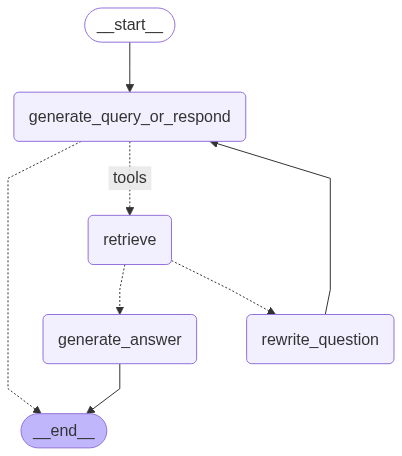

In [299]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [300]:
from typing import Dict

for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "더불어 민주당의 ‘청년미래적금’ 정책이 뭔지 설명해줘",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        if isinstance(update["messages"][-1], Dict):
            print(update["messages"][-1]['content'])
        else:
            update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  policy_search (3a93e35b-9202-4766-96e8-f0946c9ecbb3)
 Call ID: 3a93e35b-9202-4766-96e8-f0946c9ecbb3
  Args:
    query: 더불어 민주당 청년미래적금



Update from node retrieve
================================= Tool Message =================================
Name: policy_search

- 양곡관리법 개정 등을 통한 쌀값 정상화 및 공익직불금 확대
- 농업인 퇴직연금제 도입 및 농지이양 은퇴직불금‧공공비축농지 확대
○어민 소득증대 통한 어촌소멸 대응
- 탄소중립 활동 참여 어촌마을 안정적인 소득기반 마련

○대환대출 활성화 및 중도상환수수료 단계적 감면 등 대출상환 부담 완화 
○취약계층에 대한 중금리대출 전문 인터넷은행 추진
○가산금리 산정 시 법적비용의 금융소비자 부당전가 방지로 원리금상환부담 경감
○채무자 중심의 보호체계 구축 및 사각지대 해소

- 오토바이 전후방 번호판제 도입 및 고령운전자 운전 안전 대책 마련 
- 전기차 배터리 인증제 활성화 및 전기차 화재예방·진압장비 도입 확대  
- 공유형 전동킥보드 안전관리 강화 및 효율적 이용을 위한 관련법 제정
- 항공사고 예방을 위한 항공사·공항시설 안전관련 투자·정비 점검 강화 
- 건설공사 발주ㆍ설계ㆍ시공ㆍ감리 등 전 과정에 대한 안전대책 강화
○지역·필수·공공의료 강화로 제대로 치료받을 권리 확보

- 한미동맹 기반 하 전시작전권 환수 추진
○국제사회에서의 공헌과 국격에 걸맞은 외교 추진
- UN 등 국제기구에서의 적극적 역할 확대, 글로벌 기후위기 대응외교 강화
- 국제개

In [301]:
update

{'messages': [AIMessage(content="죄송합니다. 더불어민주당의 정책 중에서 '청년미래적금'에 대한 구체적인 내용은 찾을 수 없었습니다. 다른 정책에 대해 알아보시거나, 더 구체적인 검색어를 사용해 다시 시도해 보시는 것을 추천드립니다.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f116fc2d-eebf-4862-8519-dbea051316d8-0', usage_metadata={'input_tokens': 843, 'output_tokens': 71, 'total_tokens': 914, 'input_token_details': {'cache_read': 0}})]}